In [16]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
tf.random.set_seed(1)
random.seed(1)

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [18]:
height = 512

In [19]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_13/Sigmoid:0', description="created by layer 'conv2d_transpose_13'")


In [20]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [21]:
valdataset = DatasetCreator(modelcreator.getpreprocess(),val_transforms)

In [22]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [23]:
trainaugmentation = albu.Compose([
    albu.Resize(height, height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])#todo change later

In [24]:
traindataset = DatasetCreator(modelcreator.getpreprocess(),trainaugmentation)

In [25]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

20

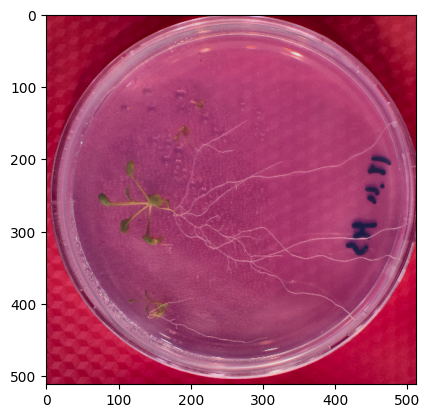

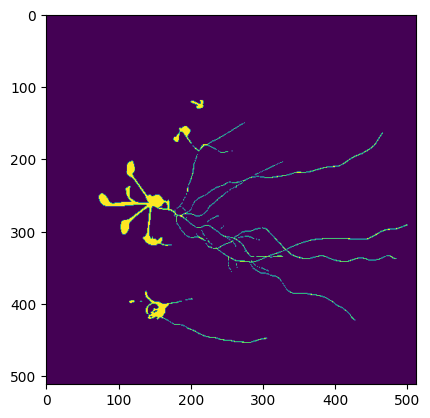

In [26]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

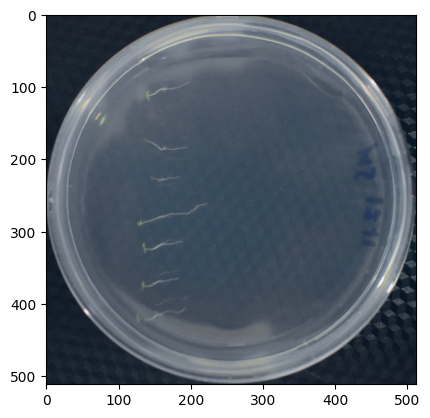

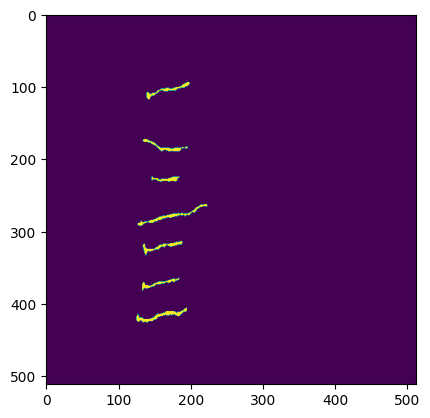

In [27]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [28]:
#tf.keras.utils.plot_model(model)

In [29]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [30]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 1.4712 - iou_score: 0.0091
Epoch 1: val_loss improved from inf to 1.42533, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 38s 2s/step - loss: 1.4712 - iou_score: 0.0091 - val_loss: 1.4253 - val_iou_score: 0.0082 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 1.0953 - iou_score: 0.0109
Epoch 2: val_loss improved from 1.42533 to 1.11713, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 1.0953 - iou_score: 0.0109 - val_loss: 1.1171 - val_iou_score: 0.0033 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 1.0511 - iou_score: 0.0160
Epoch 3: val_loss improved from 1.11713 to 1.08342, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 1.0511 - iou_score: 0.0160 - val_loss: 1.0834 - val_iou_score: 0.0040 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 1.0330 - iou_score: 0.0291
Epoch 4: val_loss did not improve from 1.08342
20/20 [==============================] - 34s 1s/step - loss: 1.0330 - iou_score: 0.0291 - val_loss: 1.0849 - val_iou_score: 0.0065 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 1.0147 - iou_score: 0.0397
Epoch 5: val_loss did not improve from 1.08342
20/20 [==============================] - 34s 1s/step - loss: 1.0147 - iou_score: 0.0397 - val_loss: 1.0852 - val_iou_score: 0.0076 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
20/20 [====================

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.9790 - iou_score: 0.0675 - val_loss: 1.0689 - val_iou_score: 0.0095 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 0.9524 - iou_score: 0.0941
Epoch 7: val_loss improved from 1.06893 to 1.06681, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.9524 - iou_score: 0.0941 - val_loss: 1.0668 - val_iou_score: 0.0088 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 0.9344 - iou_score: 0.1087
Epoch 8: val_loss improved from 1.06681 to 1.05274, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.9344 - iou_score: 0.1087 - val_loss: 1.0527 - val_iou_score: 0.0082 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 0.9029 - iou_score: 0.1337
Epoch 9: val_loss improved from 1.05274 to 1.04613, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.9029 - iou_score: 0.1337 - val_loss: 1.0461 - val_iou_score: 0.0094 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 0.8846 - iou_score: 0.1562
Epoch 10: val_loss did not improve from 1.04613
20/20 [==============================] - 33s 1s/step - loss: 0.8846 - iou_score: 0.1562 - val_loss: 1.0512 - val_iou_score: 0.0095 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: 0.8265 - iou_score: 0.2115
Epoch 11: val_loss improved from 1.04613 to 1.04463, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.8265 - iou_score: 0.2115 - val_loss: 1.0446 - val_iou_score: 0.0095 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
20/20 [==============================] - ETA: 0s - loss: 0.8385 - iou_score: 0.1984
Epoch 12: val_loss improved from 1.04463 to 1.03862, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.8385 - iou_score: 0.1984 - val_loss: 1.0386 - val_iou_score: 0.0107 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
20/20 [==============================] - ETA: 0s - loss: 0.7744 - iou_score: 0.2572
Epoch 13: val_loss improved from 1.03862 to 1.03031, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.7744 - iou_score: 0.2572 - val_loss: 1.0303 - val_iou_score: 0.0176 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 0.7404 - iou_score: 0.2953
Epoch 14: val_loss improved from 1.03031 to 1.02032, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7404 - iou_score: 0.2953 - val_loss: 1.0203 - val_iou_score: 0.0231 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 0.7651 - iou_score: 0.2729
Epoch 15: val_loss improved from 1.02032 to 1.01863, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7651 - iou_score: 0.2729 - val_loss: 1.0186 - val_iou_score: 0.0253 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 0.6995 - iou_score: 0.3311
Epoch 16: val_loss did not improve from 1.01863
20/20 [==============================] - 33s 1s/step - loss: 0.6995 - iou_score: 0.3311 - val_loss: 1.0315 - val_iou_score: 0.0196 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
20/20 [==============================] - ETA: 0s - loss: 0.7155 - iou_score: 0.3163
Epoch 17: val_loss did not improve from 1.01863
20/20 [==============================] - 33s 1s/step - loss: 0.7155 - iou_score: 0.3163 - val_loss: 1.0400 - val_iou_score: 0.0183 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
20/20 [============

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7161 - iou_score: 0.3204 - val_loss: 1.0021 - val_iou_score: 0.0501 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 0.6901 - iou_score: 0.3471
Epoch 20: val_loss improved from 1.00206 to 0.98276, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6901 - iou_score: 0.3471 - val_loss: 0.9828 - val_iou_score: 0.0723 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 0.6523 - iou_score: 0.3844
Epoch 21: val_loss improved from 0.98276 to 0.88512, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6523 - iou_score: 0.3844 - val_loss: 0.8851 - val_iou_score: 0.1554 - lr: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 0.6646 - iou_score: 0.3709 
Epoch 22: val_loss did not improve from 0.88512
20/20 [==============================] - 207s 10s/step - loss: 0.6646 - iou_score: 0.3709 - val_loss: 0.9749 - val_iou_score: 0.0863 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 0.6339 - iou_score: 0.3997
Epoch 23: val_loss improved from 0.88512 to 0.84730, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6339 - iou_score: 0.3997 - val_loss: 0.8473 - val_iou_score: 0.2009 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 0.6410 - iou_score: 0.3907
Epoch 24: val_loss improved from 0.84730 to 0.83381, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6410 - iou_score: 0.3907 - val_loss: 0.8338 - val_iou_score: 0.2076 - lr: 0.0010

Epoch 25: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 25/1000
20/20 [==============================] - ETA: 0s - loss: 0.6401 - iou_score: 0.3988
Epoch 25: val_loss improved from 0.83381 to 0.75426, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6401 - iou_score: 0.3988 - val_loss: 0.7543 - val_iou_score: 0.2921 - lr: 0.0010

Epoch 26: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: 0.6457 - iou_score: 0.3851
Epoch 26: val_loss improved from 0.75426 to 0.69803, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.6457 - iou_score: 0.3851 - val_loss: 0.6980 - val_iou_score: 0.3430 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 27/1000
20/20 [==============================] - ETA: 0s - loss: 0.6311 - iou_score: 0.4031
Epoch 27: val_loss improved from 0.69803 to 0.64797, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6311 - iou_score: 0.4031 - val_loss: 0.6480 - val_iou_score: 0.3734 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 28/1000
20/20 [==============================] - ETA: 0s - loss: 0.6541 - iou_score: 0.3858
Epoch 28: val_loss did not improve from 0.64797
20/20 [==============================] - 33s 1s/step - loss: 0.6541 - iou_score: 0.3858 - val_loss: 0.6683 - val_iou_score: 0.3611 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 29/1000
20/20 [==============================] - ETA: 0s - loss: 0.6443 - iou_score: 0.3863
Epoch 29: val_loss improved from 0.64797 to 0.64206, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6443 - iou_score: 0.3863 - val_loss: 0.6421 - val_iou_score: 0.3822 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 30/1000
20/20 [==============================] - ETA: 0s - loss: 0.6444 - iou_score: 0.3919
Epoch 30: val_loss improved from 0.64206 to 0.57372, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6444 - iou_score: 0.3919 - val_loss: 0.5737 - val_iou_score: 0.4452 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 0.6310 - iou_score: 0.4064
Epoch 31: val_loss did not improve from 0.57372
20/20 [==============================] - 33s 1s/step - loss: 0.6310 - iou_score: 0.4064 - val_loss: 0.5832 - val_iou_score: 0.4528 - lr: 9.0484e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 0.6156 - iou_score: 0.4168
Epoch 32: val_loss improved from 0.57372 to 0.56213, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6156 - iou_score: 0.4168 - val_loss: 0.5621 - val_iou_score: 0.4689 - lr: 9.0484e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 0.6124 - iou_score: 0.4233
Epoch 33: val_loss improved from 0.56213 to 0.52010, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6124 - iou_score: 0.4233 - val_loss: 0.5201 - val_iou_score: 0.5105 - lr: 9.0484e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 34/1000
20/20 [==============================] - ETA: 0s - loss: 0.6182 - iou_score: 0.4191
Epoch 34: val_loss improved from 0.52010 to 0.50739, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6182 - iou_score: 0.4191 - val_loss: 0.5074 - val_iou_score: 0.5126 - lr: 9.0484e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 35/1000
20/20 [==============================] - ETA: 0s - loss: 0.5859 - iou_score: 0.4420
Epoch 35: val_loss did not improve from 0.50739
20/20 [==============================] - 33s 1s/step - loss: 0.5859 - iou_score: 0.4420 - val_loss: 0.5079 - val_iou_score: 0.5233 - lr: 9.0484e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 36/1000
20/20 [==============================] - ETA: 0s - loss: 0.6000 - iou_score: 0.4317
Epoch 36: val_loss improved from 0.50739 to 0.50149, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.6000 - iou_score: 0.4317 - val_loss: 0.5015 - val_iou_score: 0.5277 - lr: 9.0484e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 37/1000
20/20 [==============================] - ETA: 0s - loss: 0.6352 - iou_score: 0.4039
Epoch 37: val_loss did not improve from 0.50149
20/20 [==============================] - 33s 1s/step - loss: 0.6352 - iou_score: 0.4039 - val_loss: 0.5253 - val_iou_score: 0.5005 - lr: 9.0484e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 38/1000
20/20 [==============================] - ETA: 0s - loss: 0.6116 - iou_score: 0.4238
Epoch 38: val_loss did not improve from 0.50149
20/20 [==============================] - 33s 1s/step - loss: 0.6116 - iou_score: 0.4238 - val_loss: 0.5050 - val_iou_score: 0.5242 - lr: 9.0484e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 39/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6015 - iou_score: 0.4330 - val_loss: 0.4786 - val_iou_score: 0.5415 - lr: 9.0484e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 40/1000
20/20 [==============================] - ETA: 0s - loss: 0.6109 - iou_score: 0.4252
Epoch 40: val_loss improved from 0.47857 to 0.46363, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6109 - iou_score: 0.4252 - val_loss: 0.4636 - val_iou_score: 0.5586 - lr: 9.0484e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 0.6083 - iou_score: 0.4247
Epoch 41: val_loss did not improve from 0.46363
20/20 [==============================] - 33s 1s/step - loss: 0.6083 - iou_score: 0.4247 - val_loss: 0.4900 - val_iou_score: 0.5387 - lr: 9.0484e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 0.5969 - iou_score: 0.4392
Epoch 42: val_loss did not improve from 0.46363
20/20 [==============================] - 33s 1s/step - loss: 0.5969 - iou_score: 0.4392 - val_loss: 0.4978 - val_iou_score: 0.5336 - lr: 9.0484e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 43/1000


2023-10-05 16:19:00.547178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 51 of 100
2023-10-05 16:19:00.635115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 52 of 100
2023-10-05 16:19:00.727794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 53 of 100
2023-10-05 16:19:00.776901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 54 of 100
2023-10-05 16:19:00.914938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 55 of 100
2023-10-05 16:19:00.986720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 56 of 100
2023-10-05 16:19:01.075916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this 

20/20 [==============================] - ETA: 0s - loss: 0.6050 - iou_score: 0.4307
Epoch 43: val_loss did not improve from 0.46363
20/20 [==============================] - 211s 1s/step - loss: 0.6050 - iou_score: 0.4307 - val_loss: 0.4959 - val_iou_score: 0.5286 - lr: 9.0484e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 44/1000
20/20 [==============================] - ETA: 0s - loss: 0.5935 - iou_score: 0.4373
Epoch 44: val_loss did not improve from 0.46363
20/20 [==============================] - 33s 1s/step - loss: 0.5935 - iou_score: 0.4373 - val_loss: 0.4870 - val_iou_score: 0.5456 - lr: 9.0484e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 45/1000
20/20 [==============================] - ETA: 0s - loss: 0.6100 - iou_score: 0.4227
Epoch 45: val_loss did not improve from 0.46363
20/20 [==============================] - 33s 1s/step - loss: 0.6100 - iou_score: 0.4227 - val_loss: 0.4877 - val_iou_

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.6046 - iou_score: 0.4256 - val_loss: 0.4405 - val_iou_score: 0.5809 - lr: 8.1873e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 54/1000
20/20 [==============================] - ETA: 0s - loss: 0.5949 - iou_score: 0.4386
Epoch 54: val_loss did not improve from 0.44052
20/20 [==============================] - 33s 1s/step - loss: 0.5949 - iou_score: 0.4386 - val_loss: 0.4445 - val_iou_score: 0.5850 - lr: 8.1873e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 55/1000
20/20 [==============================] - ETA: 0s - loss: 0.5947 - iou_score: 0.4408
Epoch 55: val_loss did not improve from 0.44052
20/20 [==============================] - 33s 1s/step - loss: 0.5947 - iou_score: 0.4408 - val_loss: 0.4711 - val_iou_score: 0.5553 - lr: 8.1873e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 56/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5659 - iou_score: 0.4679 - val_loss: 0.4276 - val_iou_score: 0.5941 - lr: 7.4082e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 65/1000
20/20 [==============================] - ETA: 0s - loss: 0.5661 - iou_score: 0.4663
Epoch 65: val_loss did not improve from 0.42756
20/20 [==============================] - 34s 1s/step - loss: 0.5661 - iou_score: 0.4663 - val_loss: 0.4524 - val_iou_score: 0.5698 - lr: 7.4082e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 66/1000
20/20 [==============================] - ETA: 0s - loss: 0.5893 - iou_score: 0.4446
Epoch 66: val_loss did not improve from 0.42756
20/20 [==============================] - 33s 1s/step - loss: 0.5893 - iou_score: 0.4446 - val_loss: 0.4558 - val_iou_score: 0.5747 - lr: 7.4082e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 67/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 39s 2s/step - loss: 0.5402 - iou_score: 0.4920 - val_loss: 0.4250 - val_iou_score: 0.6045 - lr: 6.7032e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 80/1000
20/20 [==============================] - ETA: 0s - loss: 0.5633 - iou_score: 0.4709
Epoch 80: val_loss did not improve from 0.42498
20/20 [==============================] - 35s 1s/step - loss: 0.5633 - iou_score: 0.4709 - val_loss: 0.4637 - val_iou_score: 0.5689 - lr: 6.7032e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 81/1000
20/20 [==============================] - ETA: 0s - loss: 0.5881 - iou_score: 0.4457
Epoch 81: val_loss did not improve from 0.42498
20/20 [==============================] - 39s 2s/step - loss: 0.5881 - iou_score: 0.4457 - val_loss: 0.4799 - val_iou_score: 0.5472 - lr: 6.7032e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 82/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.5403 - iou_score: 0.4922 - val_loss: 0.4187 - val_iou_score: 0.6045 - lr: 6.0653e-04

Epoch 100: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 100/1000
20/20 [==============================] - ETA: 0s - loss: 0.5544 - iou_score: 0.4771
Epoch 100: val_loss did not improve from 0.41871
20/20 [==============================] - 33s 1s/step - loss: 0.5544 - iou_score: 0.4771 - val_loss: 0.4458 - val_iou_score: 0.5764 - lr: 6.0653e-04

Epoch 101: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 101/1000
20/20 [==============================] - ETA: 0s - loss: 0.5522 - iou_score: 0.4802
Epoch 101: val_loss improved from 0.41871 to 0.40774, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.5522 - iou_score: 0.4802 - val_loss: 0.4077 - val_iou_score: 0.6171 - lr: 6.0653e-04

Epoch 102: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 102/1000
20/20 [==============================] - ETA: 0s - loss: 0.5311 - iou_score: 0.4948
Epoch 102: val_loss did not improve from 0.40774
20/20 [==============================] - 33s 1s/step - loss: 0.5311 - iou_score: 0.4948 - val_loss: 0.4613 - val_iou_score: 0.5690 - lr: 6.0653e-04

Epoch 103: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 103/1000
20/20 [==============================] - ETA: 0s - loss: 0.5363 - iou_score: 0.4951
Epoch 103: val_loss did not improve from 0.40774
20/20 [==============================] - 33s 1s/step - loss: 0.5363 - iou_score: 0.4951 - val_loss: 0.4670 - val_iou_score: 0.5609 - lr: 6.0653e-04

Epoch 104: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 104/1000

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 36s 2s/step - loss: 0.5383 - iou_score: 0.4913 - val_loss: 0.4052 - val_iou_score: 0.6141 - lr: 6.0653e-04

Epoch 106: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 106/1000
20/20 [==============================] - ETA: 0s - loss: 0.5441 - iou_score: 0.4864
Epoch 106: val_loss did not improve from 0.40519
20/20 [==============================] - 33s 1s/step - loss: 0.5441 - iou_score: 0.4864 - val_loss: 0.4187 - val_iou_score: 0.6015 - lr: 5.4881e-04

Epoch 107: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 107/1000
20/20 [==============================] - ETA: 0s - loss: 0.5490 - iou_score: 0.4830
Epoch 107: val_loss did not improve from 0.40519
20/20 [==============================] - 33s 1s/step - loss: 0.5490 - iou_score: 0.4830 - val_loss: 0.4548 - val_iou_score: 0.5704 - lr: 5.4881e-04

Epoch 108: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 108/1000

2023-10-05 17:04:31.699897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 47 of 100
2023-10-05 17:04:31.817303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 48 of 100
2023-10-05 17:04:31.914229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 49 of 100
2023-10-05 17:04:32.007064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 50 of 100
2023-10-05 17:04:32.090946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 51 of 100
2023-10-05 17:04:32.162988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 52 of 100
2023-10-05 17:04:32.251998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this 

20/20 [==============================] - ETA: 0s - loss: 0.5305 - iou_score: 0.4998
Epoch 112: val_loss did not improve from 0.40519
20/20 [==============================] - 186s 1s/step - loss: 0.5305 - iou_score: 0.4998 - val_loss: 0.4420 - val_iou_score: 0.5863 - lr: 5.4881e-04

Epoch 113: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 113/1000
20/20 [==============================] - ETA: 0s - loss: 0.5271 - iou_score: 0.5025
Epoch 113: val_loss did not improve from 0.40519
20/20 [==============================] - 33s 1s/step - loss: 0.5271 - iou_score: 0.5025 - val_loss: 0.4389 - val_iou_score: 0.5864 - lr: 5.4881e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 114/1000
20/20 [==============================] - ETA: 0s - loss: 0.5515 - iou_score: 0.4790
Epoch 114: val_loss did not improve from 0.40519
20/20 [==============================] - 33s 1s/step - loss: 0.5515 - iou_score: 0.4790 - val_loss: 0.4567 - v

In [31]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [32]:
results = model.evaluate(testdata)
results

10/10 [==============================] - 2s 102ms/step - loss: 0.4693 - iou_score: 0.5766


[0.4693034291267395, 0.5766481161117554]

In [33]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 106ms/step
